In [1]:
import pandas as pd
import glob
import statsmodels.api as sm
import xgboost
import catboost

from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
from auto_ts import auto_timeseries
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn import tree
from sklearn.metrics import mean_squared_error

Imported auto_timeseries version:0.0.37. Call by using:
model = auto_timeseries(score_type='rmse',
                time_interval='M',
                non_seasonal_pdq=None, seasonality=False, seasonal_period=12,
                model_type=['best'],
                verbose=2)
model.fit(traindata, ts_column,target)
model.predict(testdata, model='best')



## Read Data

In [2]:
# Add past year's data
path = 'C:/Users/sutantoy/Downloads/rooroo/csv'
all_files = glob.glob(path + "/*.csv")

li = []

for file in all_files:
    file_df = pd.read_csv(file)
    
    area = file.split('\\')[1].replace('.csv','')
    file_df['area'] = area
    
    li.append(file_df)

df = pd.concat(li, axis=0, ignore_index=True)
common_cols = ['block', 'street name', 'lease commence year'] # 'lease commence year' corr to 'remaining lease (yr)'
df.drop(columns=common_cols, inplace=True)

# Add even more historical data
hist_path = 'C:/Users/sutantoy/Downloads/rooroo/Jan2017ToOct2020'
hist_all_files = glob.glob(hist_path + "/*.csv")

hist_li = []

for file in hist_all_files:
    file_df = pd.read_csv(file)
    
    area = file.split('\\')[1].replace('.csv','')
    file_df['area'] = area
    
    hist_li.append(file_df)

hist_df = pd.concat(hist_li, axis=0, ignore_index=True)
hist_df.drop(columns=common_cols + ['rank town', 'flat type'], inplace=True)

df = df.append(hist_df)
del hist_df

mapping = {'01 to 03': 2, 
           '04 to 06': 5, 
           '07 to 09': 8, 
           '10 to 12': 11, 
           '13 to 15': 14, 
           '16 to 18': 17, 
           '19 to 21': 20,
           '22 to 24': 23,
           '25 to 27': 26,
           '28 to 30': 29,
           '31 to 33': 36,
           '34 to 36': 35,
           '37 to 39': 38,
           '40 to 42': 41,
           '43 to 45': 44,
           '46 to 48': 47,
           '01 TO 03': 2, 
           '04 TO 06': 5, 
           '07 TO 09': 8, 
           '10 TO 12': 11, 
           '13 TO 15': 14, 
           '16 TO 18': 17, 
           '19 TO 21': 20,
           '22 TO 24': 23,
           '25 TO 27': 26,
           '28 TO 30': 29,
           '31 TO 33': 36,
           '34 TO 36': 35,
           '37 TO 39': 38,
           '40 TO 42': 41,
           '43 TO 45': 44,
           '46 TO 48': 47}
df['storey'] = df['storey'].map(mapping)

df = df[df['storey'] >= 16]

ts_df = df

df = df.drop(columns=['resale registration date'])

display(df.head())
print(df.shape)
print(df['area'].value_counts())

,storey,floor area (sqm),flat model,remaining lease (yr),resale price ($),area
74,26,70,Model A,90.00,530000,Ang Mo Kio
225,26,70,Model A,90.33,543000,Ang Mo Kio
299,17,67,Model A,93.67,455000,Ang Mo Kio
342,20,67,Model A,93.75,473000,Ang Mo Kio
344,29,70,Model A,90.58,510000,Ang Mo Kio


(1032, 6)
Queenstown       302
Bukit Merah      257
Whampoa          115
Clementi         100
Central Area      95
Toa Payoh         48
Ang Mo Kio        40
Hougang           29
Marine Parade     25
Bedok             21
Name: area, dtype: int64


## Time Series

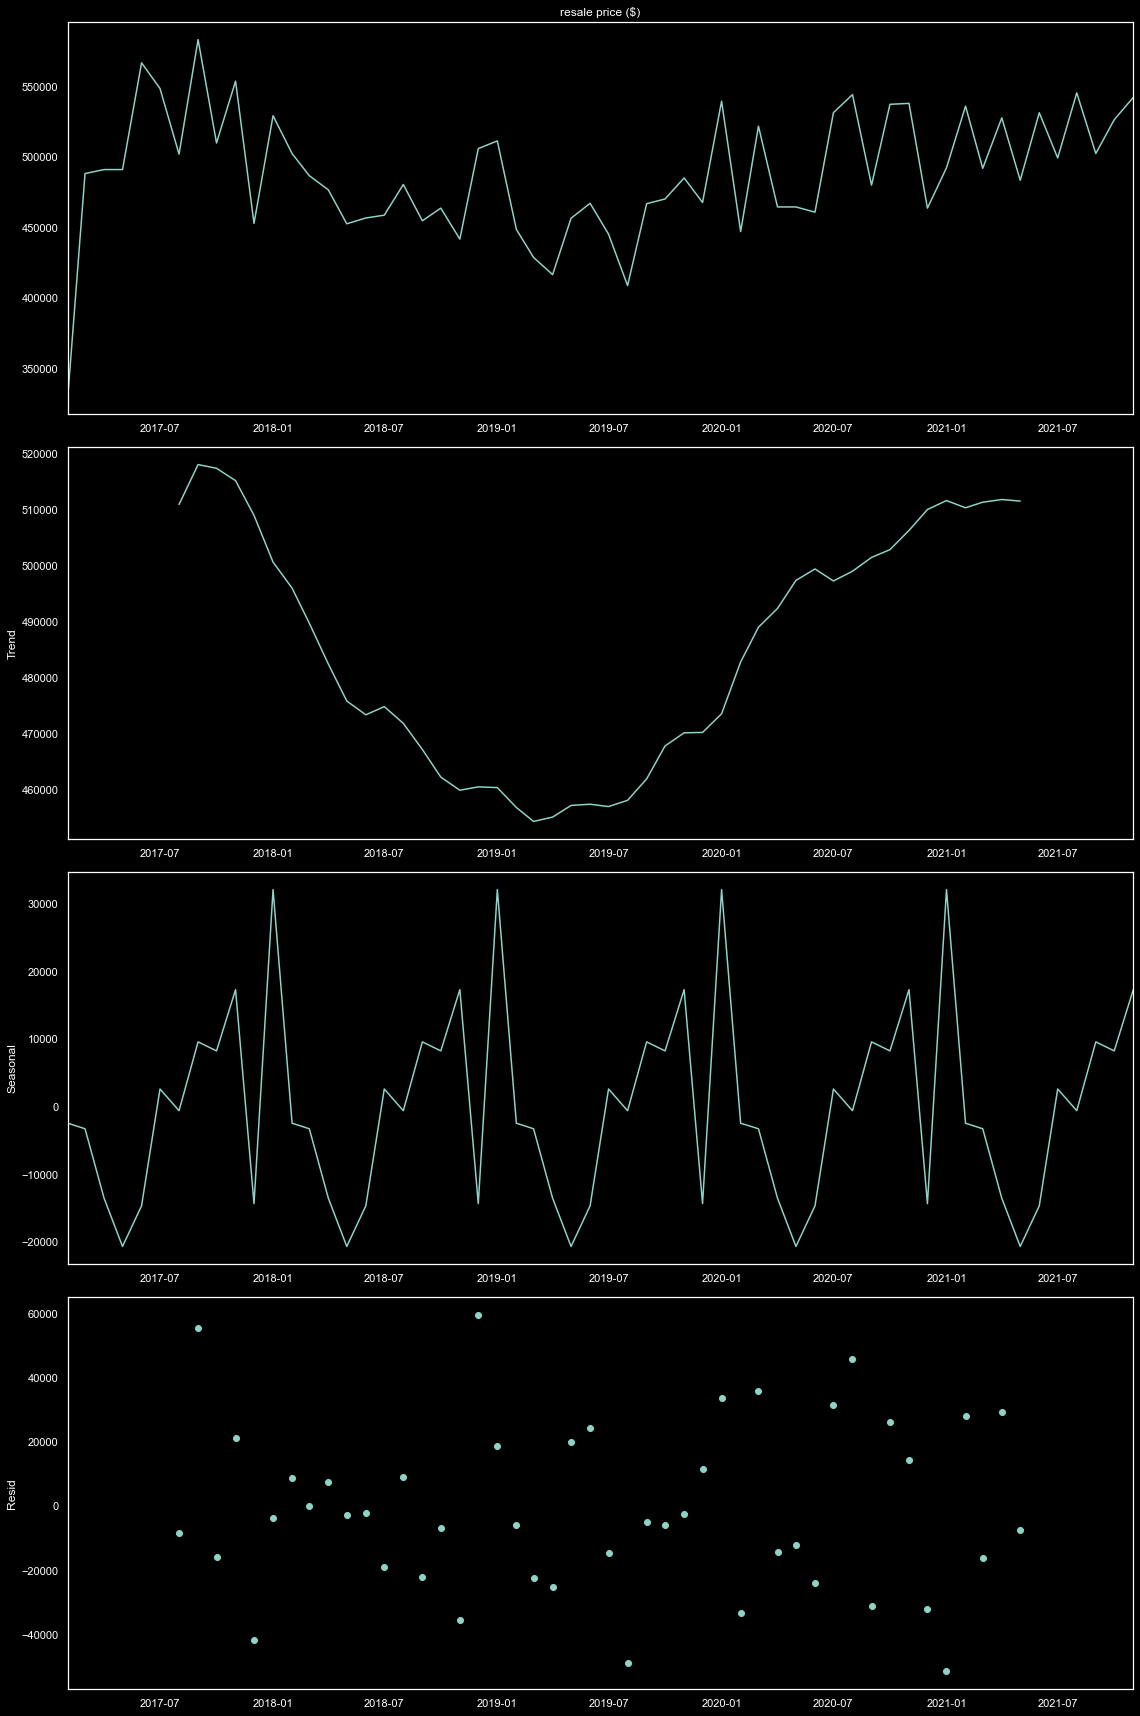

In [3]:
ts_df['resale registration date'] = pd.to_datetime(ts_df['resale registration date'])
ts_df = ts_df.groupby(by='resale registration date').mean()
ts_df = ts_df.asfreq('MS')
#display(ts_df)  # Check for NAs
ts_df.fillna(method='backfill', inplace=True)
result = seasonal_decompose(ts_df['resale price ($)'])

plt.rcParams['figure.figsize'] = [16, 24]
plt.style.use('dark_background') 
result.plot()
plt.show()

# print(result.seasonal)

### Control for area

In [4]:
# result = seasonal_decompose(ts_df['resale price ($)'] / ts_df['floor area (sqm)'])

# plt.rcParams['figure.figsize'] = [16, 24]
# plt.style.use('dark_background') 
# result.plot()
# plt.show()

#print(result.seasonal)

### Time Series Modelling

#### AutoTS

Start of Fit.....
    Target variable given as = resale price ($)
Start of loading of data.....
Input is data frame. Performing Time Series Analysis
ts_column: resale registration date sep: , target: resale price ($)
    Loaded pandas dataframe...
    pandas Dataframe loaded successfully. Shape of data set = (58, 4)
No time series plot since verbose = 0. Continuing
Time Interval is given as MS
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
  Starting Prophet Fit
       Adding monthly seasonality to Prophet with period=12, fourier_order=12 and prior_scale=0.10
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 5

Fold Number: 1 --> Train Shape: 33 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 99,476.08
    Std Deviation of actuals = 34,068.94
    Normalized RMSE = 292%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape

 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=1130.464, Time=0.14 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1128.416, Time=0.10 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=1131.755, Time=0.22 sec
 ARIMA(1,0,0)(1,0,0)[12]             : AIC=1124.375, Time=0.03 sec

Best model:  ARIMA(1,0,0)(1,0,0)[12] intercept
Total fit time: 2.060 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1217.344, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1217.308, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1216.165, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1370.056, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1219.106, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1213.734, Time=0.18 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=1214.651, Time=0.29 sec
 ARIMA(0,1,1)(0,0,3)[12] intercept   : AIC=1213.165, Time=0.27 sec
 ARIMA(0,1,1)

 Iteration 5 completed
 Iteration 6 completed
 Iteration 7 completed
 Iteration 8 completed
 Iteration 9 completed
 Iteration 10 completed
 Iteration 11 completed
 Iteration 12 completed
 Iteration 13 completed
 Iteration 14 completed
 Iteration 15 completed
 Iteration 16 completed
    Best AR order p = 3, MA order q = 0, Interim metric = 1065.046

Additional Variable in VAR model = floor area (sqm)
 Iteration 17 completed
 Iteration 18 completed
 Iteration 19 completed
 Iteration 20 completed
 Iteration 21 completed
 Iteration 22 completed
 Iteration 23 completed
 Iteration 24 completed
 Iteration 25 completed
 Iteration 26 completed
 Iteration 27 completed
 Iteration 28 completed
 Iteration 29 completed
 Iteration 30 completed
 Iteration 31 completed
 Iteration 32 completed
    Best AR order p = 0, MA order q = 2, Interim metric = 1041.736

Additional Variable in VAR model = remaining lease (yr)
 Iteration 33 completed
 Iteration 34 completed
 Iteration 35 completed
 Iteration 36 com

    Root Mean Squared Error predictions vs actuals = 29,719.42
    Std Deviation of actuals = 30,289.73
    Normalized RMSE = 98%
Cross Validation window: 3 completed

Fold Number: 4 --> Train Shape: 44 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 38,166.93
    Std Deviation of actuals = 21,869.61
    Normalized RMSE = 175%
Cross Validation window: 4 completed

Fold Number: 5 --> Train Shape: 49 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 57,038.31
    Std Deviation of actuals = 19,339.62
    Normalized RMSE = 295%
Cross Validation window: 5 completed

-------------------------------------------
Model Cross Validation Results:
-------------------------------------------
    MAE (as % Std Dev of Actuals) = 110.19%
    MAPE (Mean Absolute Percent Error) = 7%
    RMSE (Root Mean Squared Error) = 40950.0641
    Normalized RMSE (MinMax) = 42%
    Normalized RMSE (as Std Dev of Actuals)= 127%
Average CV RMSE of all predictions (micro) = 40950.0641

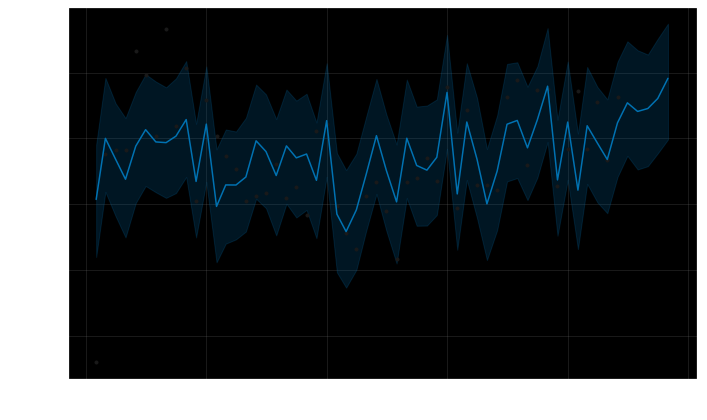

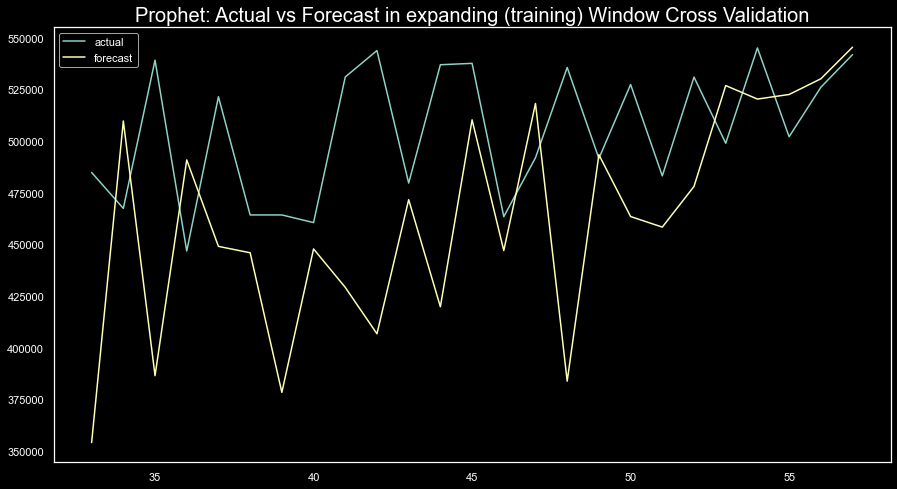

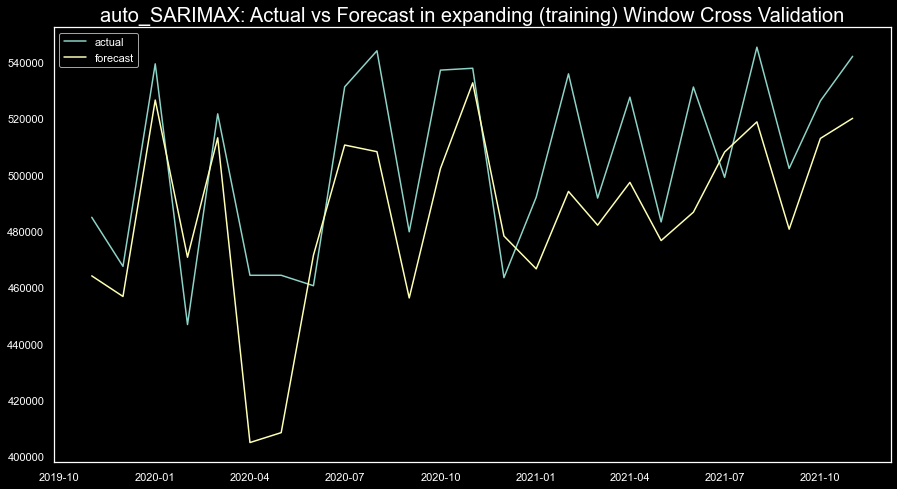

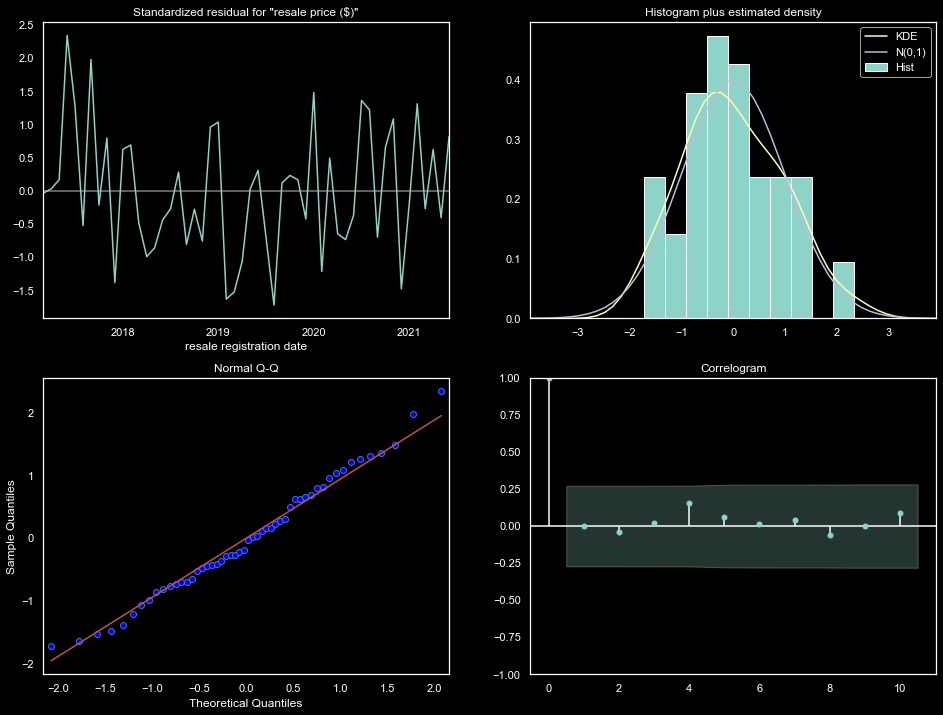

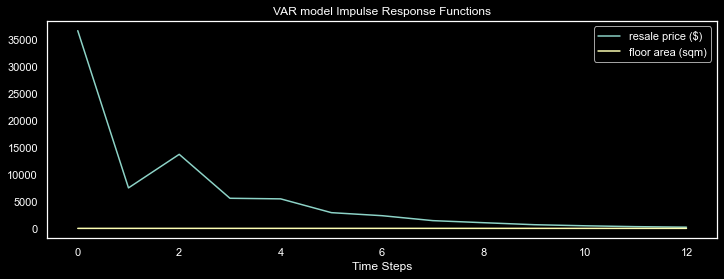

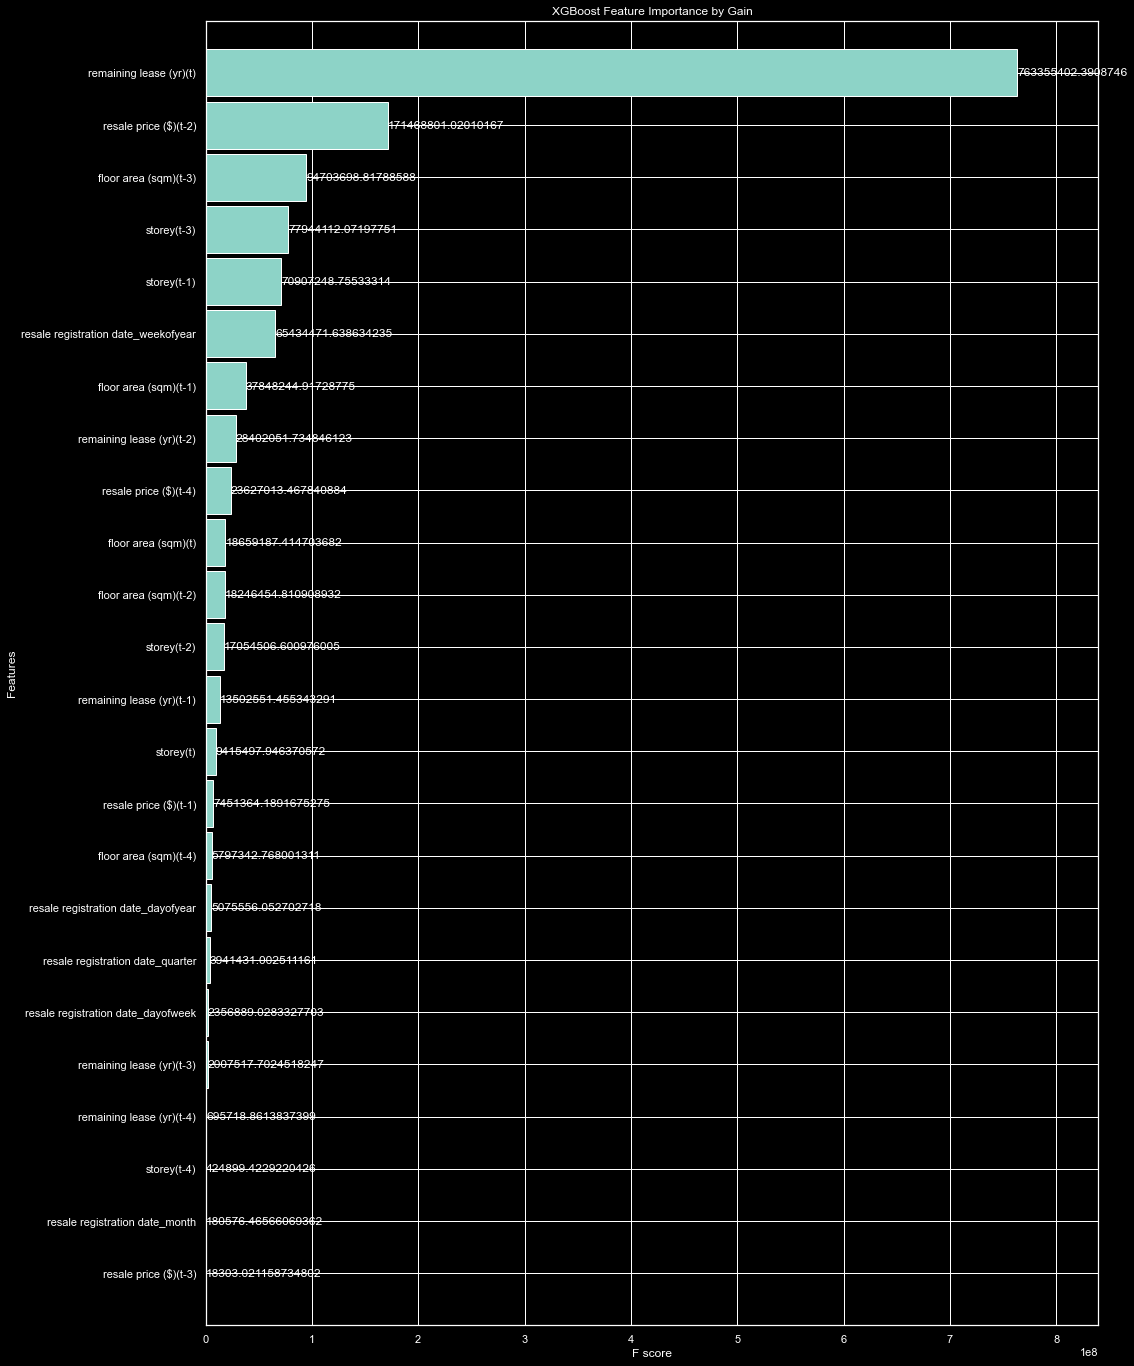

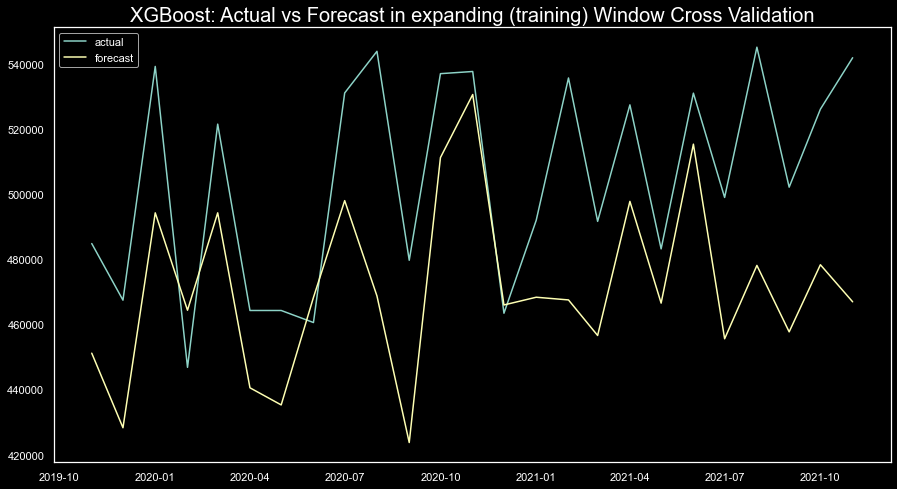

In [5]:
ts_model = auto_timeseries(time_interval='MS', seasonality=True, model_type='best')
ts_model.fit(ts_df, 'resale registration date', 'resale price ($)')

In [6]:
# average to compare rmse to
print(f"autoTS RMSE: {ts_model.get_leaderboard().iloc[0,1]}")
print(f"Comparative proportion: {ts_model.get_leaderboard().iloc[0,1] / ts_df['resale price ($)'].mean() * 100}%")

autoTS RMSE: 26205.04209190002
Comparative proportion: 5.359500177658583%


#### Univariate Analysis/Prediction

Start of Fit.....
    Target variable given as = resale price ($)
Start of loading of data.....
Input is data frame. Performing Time Series Analysis
ts_column: resale registration date sep: , target: resale price ($)
    Loaded pandas dataframe...
    pandas Dataframe loaded successfully. Shape of data set = (58, 1)
No time series plot since verbose = 0. Continuing
Time Interval is given as MS
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
  Starting Prophet Fit
       Adding monthly seasonality to Prophet with period=12, fourier_order=12 and prior_scale=0.10
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 5

Fold Number: 1 --> Train Shape: 33 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 99,476.08
    Std Deviation of actuals = 34,068.94
    Normalized RMSE = 292%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape

 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=1286.549, Time=0.23 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=1286.299, Time=0.15 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=1284.560, Time=0.11 sec
 ARIMA(2,0,0)(0,0,2)[12] intercept   : AIC=1285.668, Time=0.24 sec
 ARIMA(2,0,0)(1,0,2)[12] intercept   : AIC=1287.668, Time=0.42 sec
 ARIMA(3,0,0)(0,0,1)[12] intercept   : AIC=1286.246, Time=0.15 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=1286.305, Time=0.14 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=1287.417, Time=0.08 sec
 ARIMA(3,0,1)(0,0,1)[12] intercept   : AIC=1288.045, Time=0.23 sec
 ARIMA(2,0,0)(0,0,1)[12]             : AIC=1293.986, Time=0.10 sec

Best model:  ARIMA(2,0,0)(0,0,1)[12] intercept
Total fit time: 3.047 seconds

SARIMAX RMSE (all folds): 41191.7720
SARIMAX Norm RMSE (all folds): 94%


-------------------------------------------
Model Cross Validation Results:
-------------------------------------------
    MAE (as % Std Dev of Actuals) = 109.94%
    MAPE (Mea

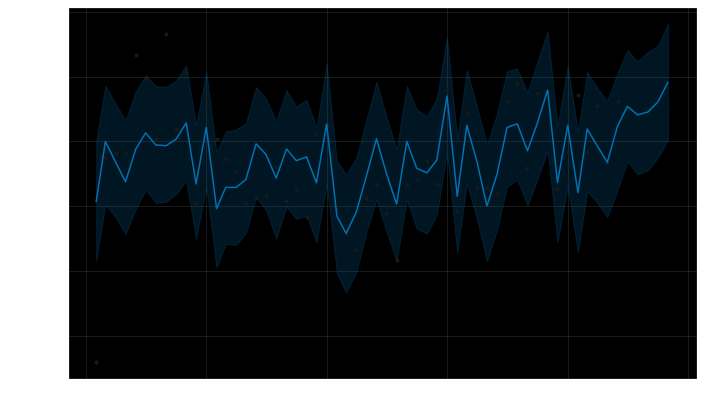

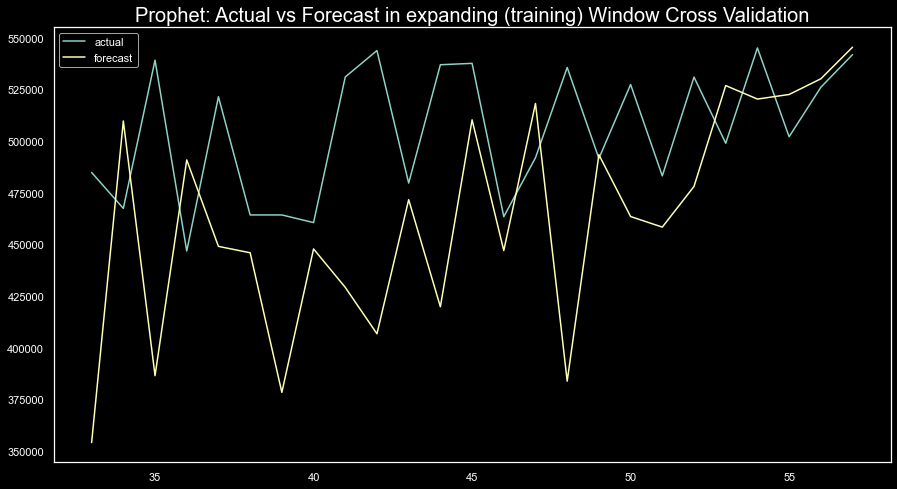

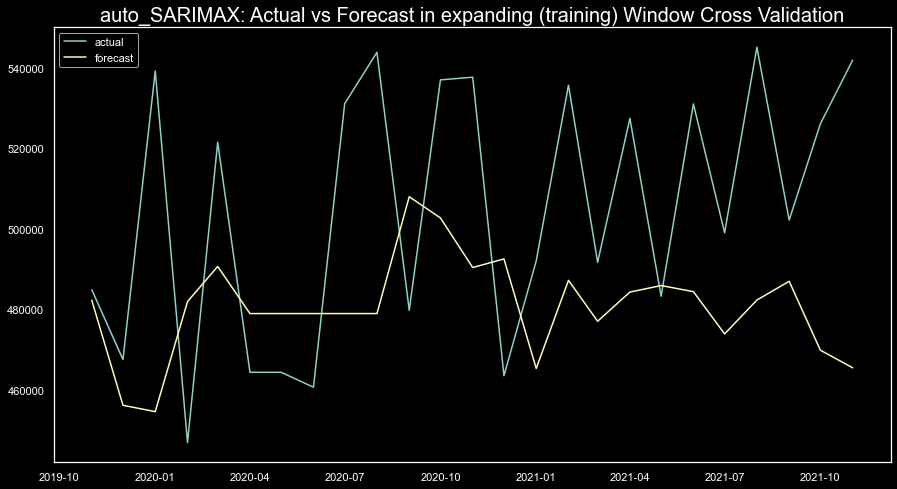

In [7]:
univariate_approaches = {'approach': list(), 'RMSE': list()}

simple_model = auto_timeseries(time_interval='MS', seasonality=True, model_type=['ARIMA', 'VAR', 'Prophet'])
simple_model.fit(ts_df.reset_index().loc[:, ['resale registration date', 'resale price ($)']], 
                 'resale registration date', 'resale price ($)')

univariate_approaches['approach'].append('autoTS')
univariate_approaches['RMSE'].append(simple_model.get_leaderboard().iloc[0,1])

#### Simple Models

In [8]:
train_df = ts_df.iloc[:-12][['resale price ($)']]
test_actuals = ts_df.iloc[-12:][['resale price ($)']]
naive_test_forecasts = ts_df.iloc[-13:][['resale price ($)']].shift(1).iloc[1:]

naive_RMSE = mean_squared_error(test_actuals, naive_test_forecasts, squared=False)
univariate_approaches['approach'].append('naive')
univariate_approaches['RMSE'].append(naive_RMSE)

SMA_test_forecasts = ts_df.rolling(12).mean().iloc[-12:][['resale price ($)']]
SMA_RMSE = mean_squared_error(test_actuals, SMA_test_forecasts, squared=False)
univariate_approaches['approach'].append('SMA')
univariate_approaches['RMSE'].append(SMA_RMSE)

SES = SimpleExpSmoothing(train_df).fit()
SES_test_forecasts = SES.forecast(12)
SES_RMSE = mean_squared_error(test_actuals, SES_test_forecasts, squared=False)
univariate_approaches['approach'].append('SES')
univariate_approaches['RMSE'].append(SES_RMSE)

HoltWinters = ExponentialSmoothing(train_df, trend='add', seasonal='add').fit()
HoltWinters_test_forecasts = HoltWinters.forecast(12)
HoltWinters_RMSE = mean_squared_error(test_actuals, HoltWinters_test_forecasts, squared=False)
univariate_approaches['approach'].append('HoltWinters (ts)')
univariate_approaches['RMSE'].append(HoltWinters_RMSE)

HoltWinters = ExponentialSmoothing(train_df, trend='add').fit()
HoltWinters_test_forecasts = HoltWinters.forecast(12)
HoltWinters_RMSE = mean_squared_error(test_actuals, HoltWinters_test_forecasts, squared=False)
univariate_approaches['approach'].append('HoltWinters (t)')
univariate_approaches['RMSE'].append(HoltWinters_RMSE)

HoltWinters = ExponentialSmoothing(train_df, seasonal='add').fit()
HoltWinters_test_forecasts = HoltWinters.forecast(12)
HoltWinters_RMSE = mean_squared_error(test_actuals, HoltWinters_test_forecasts, squared=False)
univariate_approaches['approach'].append('HoltWinters (s)')
univariate_approaches['RMSE'].append(HoltWinters_RMSE)

univariate_RMSE = pd.DataFrame.from_dict(univariate_approaches)
display(univariate_RMSE.sort_values(by='RMSE'))

,approach,RMSE
2,SMA,23136.422554
3,SES,32110.764214
6,HoltWinters (s),39764.240747
0,autoTS,41191.772033
1,naive,42376.310482
4,HoltWinters (ts),42970.253768
5,HoltWinters (t),89458.037816


In [9]:
HoltWinters = ExponentialSmoothing(ts_df[['resale price ($)']], seasonal='add').fit()
HoltWinters_future_forecasts = HoltWinters.forecast(12)

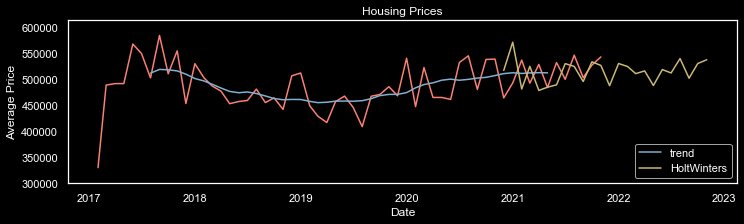

In [10]:
plt.rcParams["figure.figsize"] = (12,3)
plt.plot(ts_df)
plt.plot(result.trend, label='trend')
# plt.plot(SMA_test_forecasts, color='g', label='SMA')
# plt.plot(SES_test_forecasts, color='b', label='SES')
plt.plot(HoltWinters_test_forecasts.append(HoltWinters_future_forecasts), color='y', label='HoltWinters')

plt.ylim(bottom=300000)
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.title("Housing Prices")
plt.legend()

plt.show()

## EDA

In [11]:
df.corr()

,storey,floor area (sqm),remaining lease (yr),resale price ($)
storey,1.000000,-0.098864,0.524312,0.608901
floor area (sqm),-0.098864,1.000000,-0.085335,-0.068423
remaining lease (yr),0.524312,-0.085335,1.000000,0.800715
resale price ($),0.608901,-0.068423,0.800715,1.000000


## Traditional Regression

In [12]:
x = df.drop(columns = 'resale price ($)')
x = pd.get_dummies(x)
y = df[['resale price ($)']]

In [13]:
lr = sm.OLS(y,x)
lr.fit().summary2().tables

[                     0                 1                    2           3
 0               Model:               OLS      Adj. R-squared:       0.874
 1  Dependent Variable:  resale price ($)                 AIC:  24896.7769
 2                Date:  2022-01-07 16:25                 BIC:  24990.6227
 3    No. Observations:              1032      Log-Likelihood:     -12429.
 4            Df Model:                18         F-statistic:       399.6
 5        Df Residuals:              1013  Prob (F-statistic):        0.00
 6           R-squared:             0.877               Scale:  1.7253e+09,
                                       Coef.      Std.Err.          t  \
 storey                          1814.660571    236.176334   7.683499   
 floor area (sqm)                3872.381696    354.081032  10.936428   
 remaining lease (yr)            3537.206887    336.719918  10.504894   
 flat model_DBSS                10386.648095  25907.447960   0.400914   
 flat model_Dbss                 5

## Decision Trees

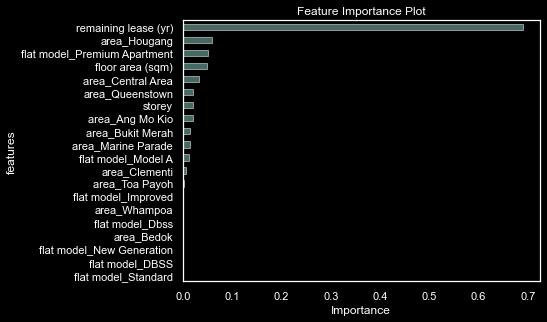

In [14]:
dt = tree.DecisionTreeRegressor().fit(x,y)

df=pd.DataFrame({'features':dt.feature_names_in_, 'importances':dt.feature_importances_})
df.sort_values('importances',inplace=True)

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
df.plot(kind='barh', x='features', y='importances', legend=False, alpha=0.5)
plt.xlabel('Importance')
plt.title('Feature Importance Plot')

plt.show()

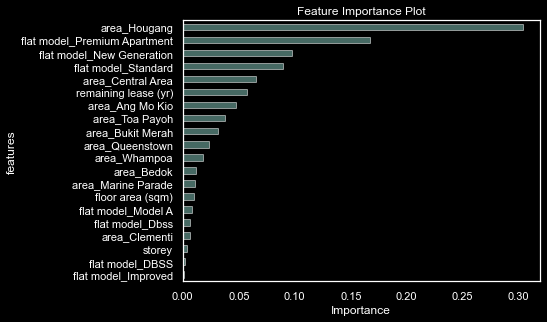

In [15]:
XG = xgboost.XGBRegressor().fit(x,y)

df=pd.DataFrame({'features':dt.feature_names_in_, 'importances':XG.feature_importances_})
df.sort_values('importances',inplace=True)

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
df.plot(kind='barh', x='features', y='importances', legend=False, alpha=0.5)
plt.xlabel('Importance')
plt.title('Feature Importance Plot')

plt.show()

In [16]:
CB = catboost.CatBoostRegressor().fit(x,y)

Learning rate set to 0.041147
0:	learn: 113774.9611951	total: 207ms	remaining: 3m 26s
1:	learn: 110813.1069509	total: 209ms	remaining: 1m 44s
2:	learn: 107625.8698427	total: 212ms	remaining: 1m 10s
3:	learn: 104846.1223114	total: 215ms	remaining: 53.4s
4:	learn: 102214.1970696	total: 217ms	remaining: 43.1s
5:	learn: 99643.8826657	total: 219ms	remaining: 36.3s
6:	learn: 97134.8641994	total: 221ms	remaining: 31.3s
7:	learn: 94854.4697443	total: 223ms	remaining: 27.6s
8:	learn: 92462.4956029	total: 224ms	remaining: 24.7s
9:	learn: 90449.6833148	total: 227ms	remaining: 22.4s
10:	learn: 88372.6122798	total: 229ms	remaining: 20.6s
11:	learn: 86045.6385484	total: 231ms	remaining: 19s
12:	learn: 84335.5059963	total: 233ms	remaining: 17.7s
13:	learn: 82407.5056823	total: 235ms	remaining: 16.6s
14:	learn: 80897.0687507	total: 237ms	remaining: 15.6s
15:	learn: 79127.4613735	total: 239ms	remaining: 14.7s
16:	learn: 77425.9050273	total: 241ms	remaining: 13.9s
17:	learn: 75954.3588978	total: 242ms	r

243:	learn: 30907.7132613	total: 540ms	remaining: 1.67s
244:	learn: 30891.1239380	total: 541ms	remaining: 1.67s
245:	learn: 30870.3782913	total: 543ms	remaining: 1.66s
246:	learn: 30834.2066175	total: 544ms	remaining: 1.66s
247:	learn: 30797.4264460	total: 546ms	remaining: 1.65s
248:	learn: 30757.5002799	total: 547ms	remaining: 1.65s
249:	learn: 30745.9567207	total: 548ms	remaining: 1.65s
250:	learn: 30729.4458931	total: 550ms	remaining: 1.64s
251:	learn: 30715.5124790	total: 552ms	remaining: 1.64s
252:	learn: 30660.4827021	total: 553ms	remaining: 1.63s
253:	learn: 30649.7122324	total: 554ms	remaining: 1.63s
254:	learn: 30588.5028523	total: 556ms	remaining: 1.62s
255:	learn: 30537.8739230	total: 557ms	remaining: 1.62s
256:	learn: 30532.9623405	total: 559ms	remaining: 1.62s
257:	learn: 30513.7584376	total: 561ms	remaining: 1.61s
258:	learn: 30479.5848559	total: 562ms	remaining: 1.61s
259:	learn: 30450.2396678	total: 563ms	remaining: 1.6s
260:	learn: 30418.6331731	total: 565ms	remaining:

478:	learn: 25494.0250347	total: 871ms	remaining: 947ms
479:	learn: 25480.6154381	total: 872ms	remaining: 945ms
480:	learn: 25479.9923701	total: 873ms	remaining: 942ms
481:	learn: 25454.4155757	total: 875ms	remaining: 940ms
482:	learn: 25445.6443521	total: 876ms	remaining: 938ms
483:	learn: 25410.7637556	total: 877ms	remaining: 935ms
484:	learn: 25394.2977570	total: 879ms	remaining: 933ms
485:	learn: 25376.8863567	total: 880ms	remaining: 931ms
486:	learn: 25358.5895971	total: 881ms	remaining: 928ms
487:	learn: 25346.4409903	total: 883ms	remaining: 926ms
488:	learn: 25322.3198738	total: 884ms	remaining: 924ms
489:	learn: 25300.2399561	total: 886ms	remaining: 922ms
490:	learn: 25276.6106436	total: 887ms	remaining: 920ms
491:	learn: 25262.8519670	total: 889ms	remaining: 918ms
492:	learn: 25248.6724800	total: 890ms	remaining: 915ms
493:	learn: 25217.9905349	total: 892ms	remaining: 913ms
494:	learn: 25210.2125111	total: 893ms	remaining: 911ms
495:	learn: 25177.0018981	total: 895ms	remaining

725:	learn: 22107.2457639	total: 1.21s	remaining: 458ms
726:	learn: 22106.9888726	total: 1.21s	remaining: 456ms
727:	learn: 22102.6750237	total: 1.22s	remaining: 454ms
728:	learn: 22101.8062818	total: 1.22s	remaining: 453ms
729:	learn: 22084.1988287	total: 1.22s	remaining: 451ms
730:	learn: 22067.2984548	total: 1.22s	remaining: 449ms
731:	learn: 22057.8161897	total: 1.22s	remaining: 447ms
732:	learn: 22043.0455404	total: 1.22s	remaining: 446ms
733:	learn: 22036.7114552	total: 1.22s	remaining: 444ms
734:	learn: 22036.4492981	total: 1.23s	remaining: 442ms
735:	learn: 22035.5641596	total: 1.23s	remaining: 440ms
736:	learn: 22029.3414017	total: 1.23s	remaining: 439ms
737:	learn: 22014.9920262	total: 1.23s	remaining: 437ms
738:	learn: 22003.4036791	total: 1.23s	remaining: 435ms
739:	learn: 21993.4409903	total: 1.23s	remaining: 433ms
740:	learn: 21991.8203380	total: 1.23s	remaining: 431ms
741:	learn: 21972.0087412	total: 1.24s	remaining: 430ms
742:	learn: 21952.7810360	total: 1.24s	remaining

965:	learn: 20262.7292482	total: 1.54s	remaining: 54.2ms
966:	learn: 20262.2798599	total: 1.54s	remaining: 52.6ms
967:	learn: 20260.4372269	total: 1.54s	remaining: 51ms
968:	learn: 20259.6358744	total: 1.54s	remaining: 49.4ms
969:	learn: 20254.6477892	total: 1.54s	remaining: 47.8ms
970:	learn: 20252.2705664	total: 1.55s	remaining: 46.2ms
971:	learn: 20252.1111300	total: 1.55s	remaining: 44.6ms
972:	learn: 20244.0543996	total: 1.55s	remaining: 43ms
973:	learn: 20243.3682448	total: 1.55s	remaining: 41.4ms
974:	learn: 20237.2515898	total: 1.55s	remaining: 39.8ms
975:	learn: 20233.7499756	total: 1.55s	remaining: 38.2ms
976:	learn: 20233.5412006	total: 1.55s	remaining: 36.6ms
977:	learn: 20225.3528097	total: 1.55s	remaining: 35ms
978:	learn: 20219.5953907	total: 1.56s	remaining: 33.4ms
979:	learn: 20205.5381050	total: 1.56s	remaining: 31.8ms
980:	learn: 20201.8705542	total: 1.56s	remaining: 30.2ms
981:	learn: 20186.5209242	total: 1.56s	remaining: 28.6ms
982:	learn: 20166.6387235	total: 1.56

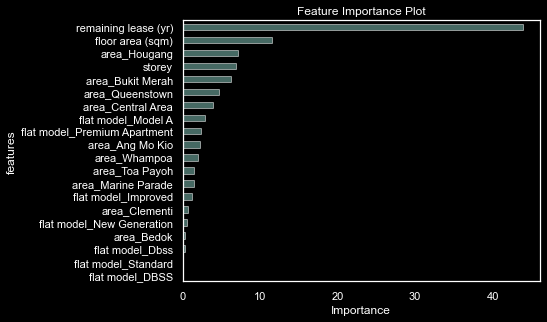

In [17]:
df=pd.DataFrame({'features':CB.feature_names_, 'importances':CB.get_feature_importance()})
df.sort_values('importances',inplace=True)

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
df.plot(kind='barh', x='features', y='importances', legend=False, alpha=0.5)
plt.xlabel('Importance')
plt.title('Feature Importance Plot')

plt.show()